<a href="https://colab.research.google.com/github/9mrcn/Data_Science/blob/master/diabetes_prediction_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data and needed libraries

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
from pandas.io.parsers.readers import read_csv
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import Markdown as md

In [2]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [3]:
# # Uncomment this cell if you downloaded a data file to your Google Drive and you want to mount your drive and use the downloaded file
# drive.mount('/content/drive/')
# diabetes_df = read_csv('/content/drive/MyDrive/DS_2.0/ML_Zadanie_1/diabetes.csv') # remember to specify your own path to the file!

In [4]:
diabetes_df = read_csv('https://raw.githubusercontent.com/9mrcn/Data_Science/master/data/diabetes.csv')

In [5]:
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Data analysis

## Missing data

In [6]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


All variables have 768 observations, so we don't have to deal with missing data

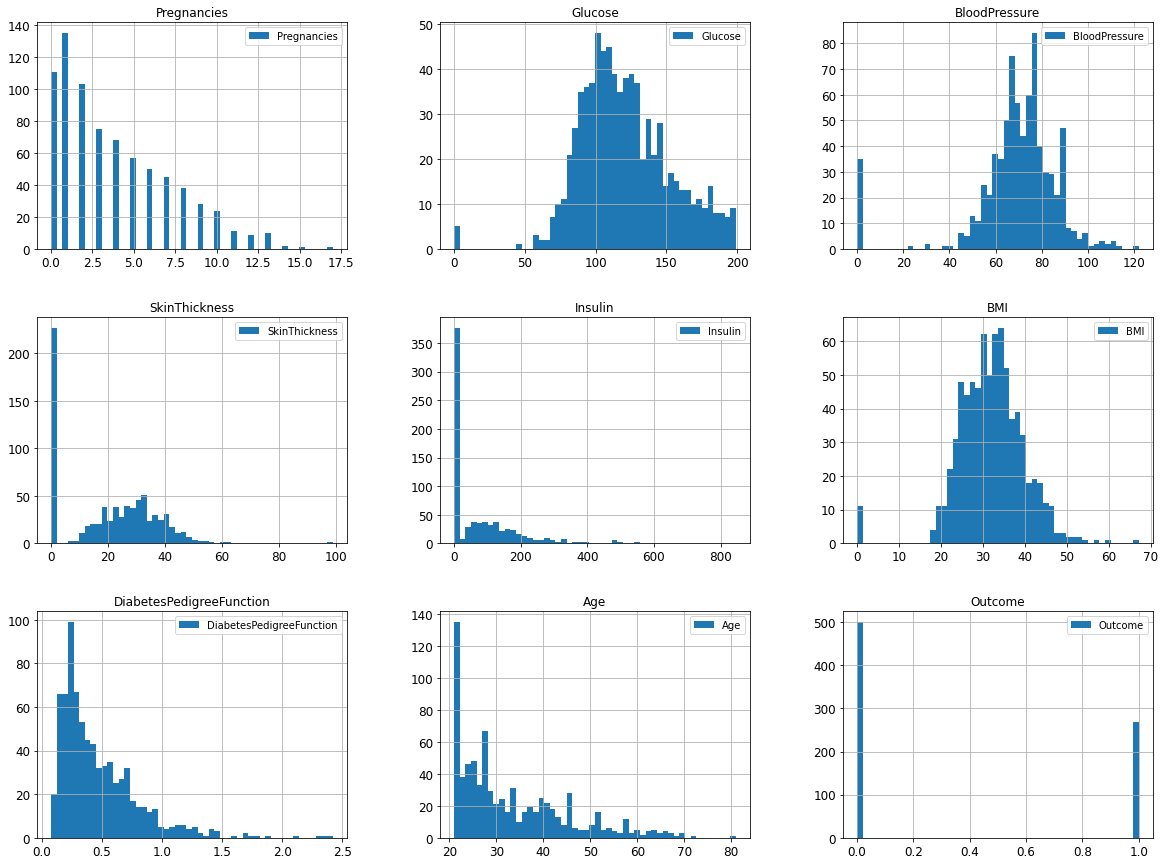

In [7]:
diabetes_df.hist(bins=50, figsize=(20,15), legend=True)
plt.show()


Previously, no data was found to be missing (as blank values in individual variables), but we can see that there is a problem - the variables Glucose, BloodPressure, SkinThickness, Insulin and BMI should not be 0. Most likely 0 means no data here. In order for these values not to affect our model, we must convert them into values that will not affect our model (the median).

In [8]:
def zero_to_median(variable_name):
  index = 0
  v_median = diabetes_df[variable_name].median()

  diabetes_df.loc[diabetes_df[variable_name]==0, variable_name] = v_median


In [9]:

for var in ('Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'):
  zero_to_median(var)

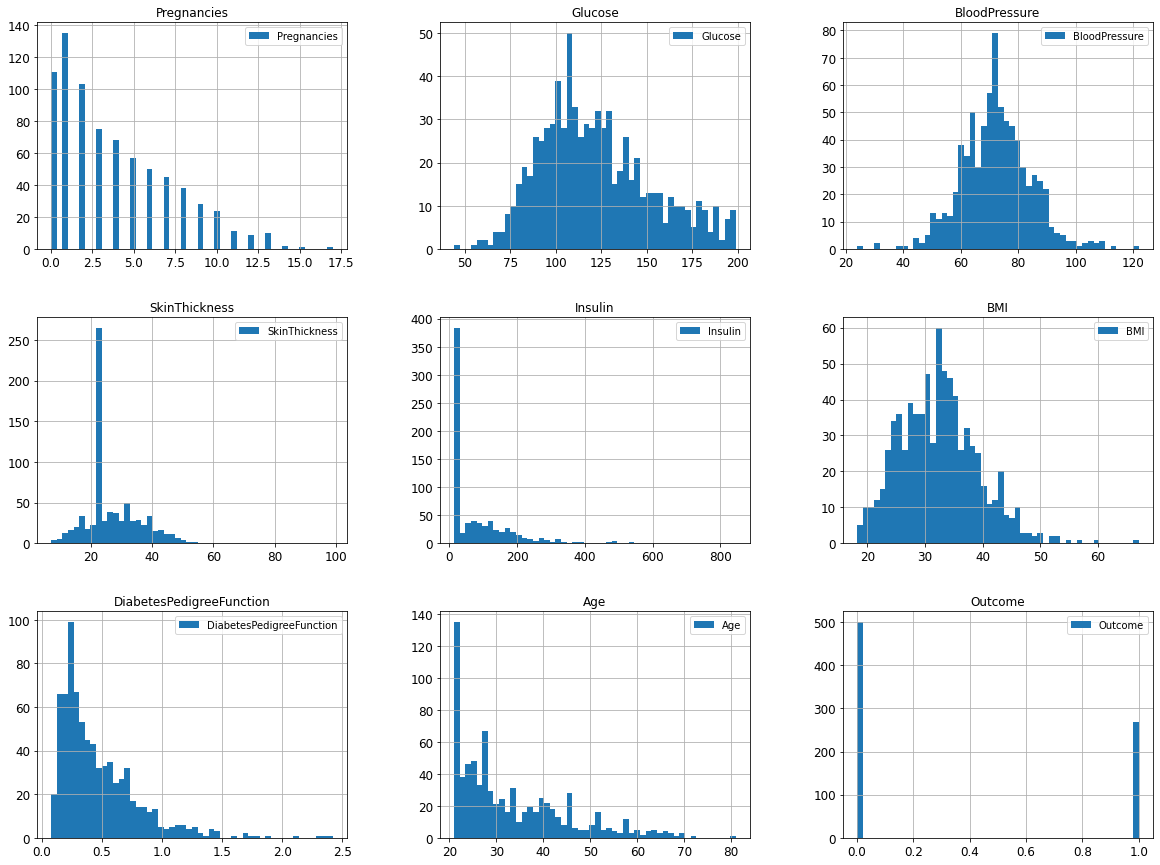

In [10]:
diabetes_df.hist(bins=50, figsize=(20,15), legend=True)
plt.show()

We successfully got rid of the zeros from the selected variables.

## Imbalanced data

In [11]:
print(diabetes_df['Outcome'].value_counts())

0    500
1    268
Name: Outcome, dtype: int64


Class 0 ('not has diabetes') is larger than class 1 ('has diabetes'). It can lead our classifier to get biased towards the prediction. We can oversample the minority class ('has diabetes') using replacement. This technique is called oversampling.

In [12]:
from imblearn.over_sampling import RandomOverSampler

In [13]:
diabetes_labels = diabetes_df['Outcome']
diabetes = diabetes_df.drop('Outcome', axis=1)

In [14]:
over_sampler = RandomOverSampler()
x, y = over_sampler.fit_resample(diabetes, diabetes_labels)


In [15]:
y.value_counts()

1    500
0    500
Name: Outcome, dtype: int64

Both classes have a similar number of records in the dataset, so we can assume that the classifier will give equal importance to both classes.

# Train-test split
We use a stratified division and the size of the test sample = 10%


In [16]:
from pandas.core.common import random_state

sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.1, random_state=42)

for train_index, test_index in sss.split(x, y):
  x_train, x_test = x.loc[train_index], x.loc[test_index]
  y_train, y_test = y.loc[train_index], y.loc[test_index]



In [17]:
print(y_train.value_counts())
print(y_test.value_counts())


0    450
1    450
Name: Outcome, dtype: int64
1    50
0    50
Name: Outcome, dtype: int64


StratifiedShuffleSplit returned train and test subsets that have equal proportions of both classes in dependent variable.

# Building models (LinearSVC, KNeighborsClassifier oraz SVC)

Oversampled, non-standardized, no feature engineering data

In [18]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

In [19]:
clf = LinearSVC(dual=False)

clf_scores = cross_val_score(clf, x_train, y_train, cv=5)
print(clf_scores)
print('Mean acc: {}'.format(clf_scores.mean()))

[0.76111111 0.76666667 0.72777778 0.77222222 0.7       ]
Mean acc: 0.7455555555555555


In [20]:
md('We get mean acc of {}%. Now we will standardize variables and see if the average accuracy of the model increases.'.format(100*round(clf_scores.mean(), 3)))

We get mean acc of 74.6%. Now we will standardize variables and see if the average accuracy of the model increases.

Standardization of variables:

In [21]:
col = x_train.columns
std = StandardScaler()
x_train_std = std.fit_transform(x_train)
x_train_std = pd.DataFrame(data = x_train_std, columns = col)

and again LinearSVC but with standardized input

In [22]:
clf_std_scores = cross_val_score(clf, x_train_std, y_train, cv=5)
print(clf_std_scores)
print('Mean acc: {}'.format(clf_std_scores.mean()))

[0.75555556 0.76111111 0.71111111 0.77777778 0.70555556]
Mean acc: 0.7422222222222222


Mean acc did improve after the variable standardization

Let's try another model.

In [23]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()

knc_score = cross_val_score(knc, x_train, y_train)
print('nonstandarized data: \ncross-validation scores: {},\nmean acc = {}\n'.format(knc_score, knc_score.mean()))

knc_std_score = cross_val_score(knc, x_train_std, y_train)
print('standarized data: \ncross-validation scores: {},\nmean acc = {}'.format(knc_std_score, knc_std_score.mean()))

nonstandarized data: 
cross-validation scores: [0.76666667 0.71111111 0.73888889 0.73888889 0.63333333],
mean acc = 0.7177777777777778

standarized data: 
cross-validation scores: [0.76666667 0.70555556 0.73333333 0.77777778 0.69444444],
mean acc = 0.7355555555555556


There is an improvement in the accuracy of the prediction both after changing the model and standardization of the variables.

Another model: SVC

In [24]:
from sklearn.svm import SVC

clf1 = SVC()

clf1_score = cross_val_score(clf1, x_train, y_train)
print('nonstandarized data:\ncross-validation scores: {},\nmean acc = {}\n'.format(clf1_score, clf1_score.mean()))

clf1_std_score = cross_val_score(clf1, x_train_std, y_train)
print('standarized data:\ncross-validation scores: {},\nmean acc = {}\n'.format(clf1_std_score, clf1_std_score.mean()))

nonstandarized data:
cross-validation scores: [0.71666667 0.75555556 0.73888889 0.76666667 0.70555556],
mean acc = 0.7366666666666667

standarized data:
cross-validation scores: [0.8        0.73888889 0.72777778 0.79444444 0.76666667],
mean acc = 0.7655555555555555



In case of SVC - once again, there is an improvement in the accuracy of the prediction both after changing the model and standardization of the variables.

# Feature engineering


We test the impact on the model after feature engineering.
New variables:
- Pregnancies -> HasBeenPregnant (whether patient was pregnant instead of how many times she was pregnant)
- BMI -> DoesBMIOk (whether BMI is normal)

In [25]:
def BMI_categorization(processing_set):
  processing_set['DoesBMIOk'] = np.zeros(processing_set.shape[0])
  processing_set.loc[((processing_set['BMI']>= 18.5) * (processing_set['BMI'] <=25)), 'DoesBMIOk'] = 1

In [26]:
def Pregnancies_categorization(processing_set):
  processing_set['HasBeenPregnant'] = np.zeros(processing_set.shape[0])
  processing_set.loc[processing_set['Pregnancies']>0, 'HasBeenPregnant'] = 1

In [27]:
BMI_categorization(x_train)
Pregnancies_categorization(x_train)

x_train_new = x_train.drop(labels=['Pregnancies', 'BMI'], axis=1 )

# Building models based on data with new variables


## Standardization and encoding data with new variables

In [28]:
# Index is reseting after standardization, so when concating dfs with numbers and categories
# there is a problem (different indexes). To avoid, we reset index before spliting and standardization.
x_train_new = x_train_new.reset_index().drop('index', axis=1)

x_train_new_num = x_train_new[['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age']]
x_train_new_cat = x_train_new[['DoesBMIOk', 'HasBeenPregnant']]

In [29]:
# standardization of numerical variables
col = x_train_new_num.columns
std = StandardScaler()
x_train_new_num_std = std.fit_transform(x_train_new_num)
x_train_new_num_std = pd.DataFrame(data = x_train_new_num_std, columns = col)

In [30]:
# encoding of categorical variables
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
x_train_new_cat_encoded = enc.fit_transform(x_train_new_cat)
x_train_new_cat_encoded = pd.DataFrame(data = x_train_new_cat_encoded, columns= ['DoesBMIOk(N)', 'DoesBMIOk(Y)', 'HasBeenPregnant(N)', 'HasBeenPregnant(Y)'])

In [31]:
# concating numerical and categorical variables into one df
x_train_new_std = pd.concat((x_train_new_num_std, x_train_new_cat_encoded), axis=1)

## Building models

In [32]:
print('LinearSVC')
clf = LinearSVC(dual=False)

clf_score = cross_val_score(clf, x_train_new, y_train)
print('nonstandarized data: \nmean acc =', clf_score.mean())

clf_std_score = cross_val_score(clf, x_train_new_std, y_train)
print('standarized data: \nmean acc =', clf_std_score.mean())


print('\nKNeighborsClassifier')
knc = KNeighborsClassifier()

knc_score = cross_val_score(knc, x_train_new, y_train)
print('nonstandarized data: \nmean acc =', knc_score.mean())

knc_std_score = cross_val_score(knc, x_train_new_std, y_train)
print('standarized data: \nmean acc =', knc_std_score.mean())


print('\nSVC')
clf1 = SVC()

clf1_score = cross_val_score(clf1, x_train_new, y_train)
print('nonstandarized data: \nmean acc =', clf1_score.mean())

clf1_std_score = cross_val_score(clf1, x_train_new_std, y_train)
print('standarized data: \nmean acc =', clf1_std_score.mean())

LinearSVC
nonstandarized data: 
mean acc = 0.7444444444444445
standarized data: 
mean acc = 0.7444444444444445

KNeighborsClassifier
nonstandarized data: 
mean acc = 0.7233333333333334
standarized data: 
mean acc = 0.7444444444444445

SVC
nonstandarized data: 
mean acc = 0.7244444444444446
standarized data: 
mean acc = 0.7666666666666666


Feature engineering did not bring the expected effect - the new variables did not improve mean acc. 
Now we try to encode our categorical values and see if this improve mean acc.


Edit: encoding of our variables did not bring any significant improvement in the accuracy of the models. It seems that for binary variables encoding has no effect or the impact is minimal (sometimes in plus and sometimes in minus).

## Testing model on test subset

Now we know that best acc has nonlinear SVC model with data after standardization but without feature engineering. Let's test it with test data.

First we have to prepare data from test subset:

- standardization

In [33]:
col = x_test.columns
std = StandardScaler()
std.fit(x_train.drop(['DoesBMIOk', 'HasBeenPregnant'], axis=1)) #!!!
x_test_std = std.transform(x_test)
x_test_std = pd.DataFrame(data = x_test_std, columns = col)

In [34]:
clf1.fit(x_train_std, y_train)
print('mean acc on training data: {}'.format(100*round(clf1.score(x_train_std, y_train), 3)))
print('mean acc on test data: {}'.format(100*round(clf1.score(x_test_std, y_test), 3)))

mean acc on training data: 84.0
mean acc on test data: 79.0


The acc for non-linear SVC is greater than it was when calculating acc with cross validation. This is due to the fact that during the cross validation we divided the training set into several smaller subsets (5 subsets) and used them several times (5 times) to achieve the average value for mean acc.

What we want to know the most is how the model is performing on the test data. Mean acc for test data is obviously lower than for training data. Now we can go completely beyond the scikit-learn package and check if the XGBoost package will help us get even better model accuracy.

# Building model (XGBClassifier from XGBoost)

In addition to basic data cleaning operations, XGBoost has several requirements to reach its top performance:
- Numeric features should be scaled (we drop x_train and stick only to x_train_std),
- Categorical features should be encoded (done before).

In [35]:
import xgboost as xgb

In [36]:
xgb_cl = xgb.XGBClassifier()

xgb_cl.fit(x_train_std, y_train)


XGBClassifier()

In [37]:
xgb_cl.score(x_train_std, y_train)

0.8822222222222222

Mean acc significantly higher than the best model results from the scikit-learn package

We move on to the tuning of the model's hyperparameters. We automate the search for the best values using GridSearchCV from the Scikit-learn library.

In [38]:
# first we have to specify hyperparmeters whose combinations we want to test
param_grid = {
    "max_depth": [4, 5, 7],
    "learning_rate": [0.01, 0.02, 0.05],
    "gamma": [0, 0.25, 0.5],
    "reg_lambda": [0, 1],
    "scale_pos_weight": [0, 1, 3, 5],
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.5]
}

In [39]:
from sklearn.model_selection import GridSearchCV

grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=5, scoring="precision")
_ = grid_cv.fit(x_train_std, y_train)

Let's check the best combination of hyperparameters provided by GridSearchCV...

In [40]:
best_params = grid_cv.best_params_
best_params

{'colsample_bytree': 0.5,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': 7,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 0.9}

...and mean acc for a model with given hyperparameters:

In [41]:
grid_cv.best_score_

0.8064700078255248

We got mean acc of ~81%, but a few of the parameters have reached their margins, let's see what happens when we set a new, extended grid param for this hyperparameters.

colsample_bytree, scale_pos_weight and reg_lambda - leave unchanged (reg_lambda cannot take a value lower than 0).

In [42]:
param_grid_1 = {
    "max_depth": [7, 10, 15],
    "learning_rate": [0.05, 0.1, 0.2],
    "gamma": [0.5, 0.75, 1],
    "reg_lambda": [0],
    "scale_pos_weight": [1],
    "subsample": [0.7, 0.8, 1],
    "colsample_bytree": [0.5]
}

In [43]:
grid_cv_1 = GridSearchCV(xgb_cl, param_grid_1, n_jobs=-1, cv=5, scoring="precision")
_ = grid_cv_1.fit(x_train_std, y_train)

In [44]:
best_params_1 = grid_cv_1.best_params_
best_params_1

{'colsample_bytree': 0.5,
 'gamma': 1,
 'learning_rate': 0.2,
 'max_depth': 10,
 'reg_lambda': 0,
 'scale_pos_weight': 1,
 'subsample': 1}

In [45]:
grid_cv_1.best_score_

0.8283323304542896

Subsample cannot have a value greater than 1, so we managed to establish the value of hyperparameters and our model achieved mean acc at the level of ~ 83%

It's time to test the model on the test sample, but first the independent variables should be standardized (NOTE! Fit on the training sample, and then transform on the test sample)

In [46]:
# fitting the model with the best hyper parameters to the training data
xgb_cl_best = xgb.XGBClassifier(**grid_cv.best_params_)

_ = xgb_cl_best.fit(x_train_std, y_train)
 
xgb_cl_best_scores = cross_val_score(xgb_cl_best, x_train_std, y_train)
print('xgb_cl_best_score (CV):', xgb_cl_best_scores.mean())

_ = xgb_cl_best.fit(x_train_std, y_train)
print('xgb_cl_best_score: ',xgb_cl_best.score(x_train_std, y_train))

xgb_cl_best_score (CV): 0.8211111111111112
xgb_cl_best_score:  0.9888888888888889


High score for the training sample without cross-validation, does it mean that we are dealing with overfitting?

In [47]:
xgb_cl_best.score(x_test_std, y_test)

0.87

The model generalizes well for the test sample, everything looks ok. Mean acc is much higher than the top models from Scikit Learn.

The next step - application of the machine learning model (with Pytorch or Tensorflow).

Stay tuned!